# A Deep Learning Approach to Music Genre Classification Using Time-Series Audio Features (GTZAN)

- **Machine Learning Algorithms**
- **José Miguel Sousa**

This notebook implements an end-to-end, reproducible Machine Learning workflow for **music genre classification** using **sequential deep learning**.  
The solution leverages **time-series features** (the GTZAN “3-second” features CSV) to build per-track sequences and trains multiple neural architectures (baseline and tuned).  
It includes: data understanding, feature engineering, model selection, hyperparameter tuning, robust evaluation, interpretability, and a lightweight deployment proof-of-concept.

## 1. Problem Definition

### 1.1 Goal

The goal of this work is to develop an intelligent system capable of automatically classifying music tracks into predefined musical genres based on audio characteristics.

Specifically, the problem addressed is the **music genre classification** task, where each input consists of time-series audio features extracted from short temporal windows of a song, and the system must assign the correct genre label to the entire track.

This problem is motivated by real-world applications such as music recommendation systems, audio content organization, and automatic metadata generation for large music libraries.

### 1.2 Success Criteria

The success of the proposed model is evaluated according to the following criteria:

- The model must correctly predict the musical genre of unseen audio tracks.
- The task is formulated as a **supervised multi-class classification** problem, where each track belongs to exactly one genre.
- Model performance is primarily assessed using the **Macro F1-score**, ensuring balanced evaluation across all genres.
- Secondary evaluation metrics include overall accuracy, precision, recall, and confusion matrix analysis.
- The model must demonstrate good generalization capability on a held-out test dataset that was not used during training or validation.

In [ ]:
import kagglehub
import shutil
from pathlib import Path

#execute once

TARGET_DIR = Path("datasets/")
TARGET_DIR.mkdir(parents=True, exist_ok=True)

cache_path = Path(
    kagglehub.dataset_download(
        "andradaolteanu/gtzan-dataset-music-genre-classification"
    )
)

print("Kagglehub cache location:", cache_path)

if not (TARGET_DIR / "features_3_seconds.csv").exists():
    shutil.copytree(cache_path, TARGET_DIR, dirs_exist_ok=True)
    print("Dataset copied to:", TARGET_DIR)
else:
    print("Dataset already exists at:", TARGET_DIR)


100%|██████████| 1.21G/1.21G [00:33<00:00, 39.4MB/s]

Extracting files...


Kagglehub cache location: C:\Users\jose.m.sousa\.cache\kagglehub\datasets\andradaolteanu\gtzan-dataset-music-genre-classification\versions\1
Dataset copied to: datasets


## 2. Data Understanding and Preparation

This phase focuses on understanding the dataset structure, identifying potential data quality issues, 
and preparing the data for training sequential deep learning models.

### 2.1 Data Source

The dataset used in this work is the **GTZAN Music Genre Dataset**, retrieved programmatically using the 
`kagglehub` library and stored locally under the `datasets/gtzan/` directory.

The dataset contains audio tracks distributed across ten musical genres, along with precomputed audio 
features extracted over fixed temporal windows.

In [10]:
import pandas as pd
from pathlib import Path

df = pd.read_csv(Path("datasets/Data/features_3_sec.csv"))
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


### 2.2 Dataset Structure

Each music track in the dataset is divided into consecutive **3-second audio segments**.  
For each segment, a set of numerical audio features is computed.

Key characteristics:
- Multiple rows correspond to the same track
- Each track is represented by approximately 10 temporal segments
- Each row contains:
  - A track identifier (`filename`)
  - A genre label
  - A set of numeric audio descriptors

This structure enables modeling the data as a **time series**.


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

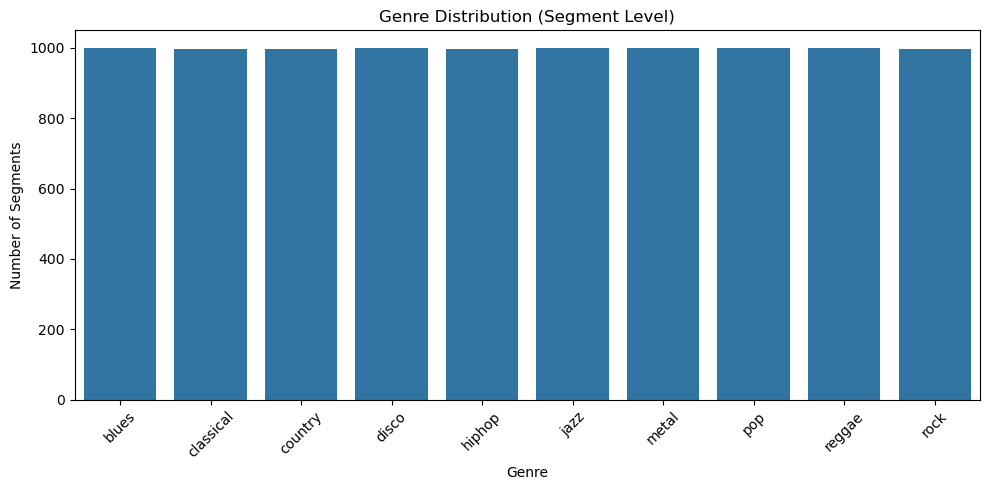

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

genre_counts = df["label"].value_counts().sort_index()

plt.figure(figsize=(10,5))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title("Genre Distribution (Segment Level)")
plt.xlabel("Genre")
plt.ylabel("Number of Segments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This figure presents the distribution of 3-second audio segments across the ten musical genres in the GTZAN dataset. Each genre is represented by approximately the same number of segments, indicating a balanced dataset at the segment level. This balance is important to prevent bias during model training and ensures that no genre disproportionately influences the learning process. Although the final classification is performed at the track level, this plot confirms that the underlying segmented data are evenly distributed across classes.

### 2.3 Data Quality Checks

Before modeling, the dataset is inspected for:
- Missing values
- Duplicate rows
- Label consistency

In [12]:
print("Missing values per column:")
print(df.isna().sum())

print("\nNumber of duplicate rows:", df.duplicated().sum())

Missing values per column:
filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean      

In addition to numerical checks, the distribution of the number of segments per track is analyzed to identify potential inconsistencies.

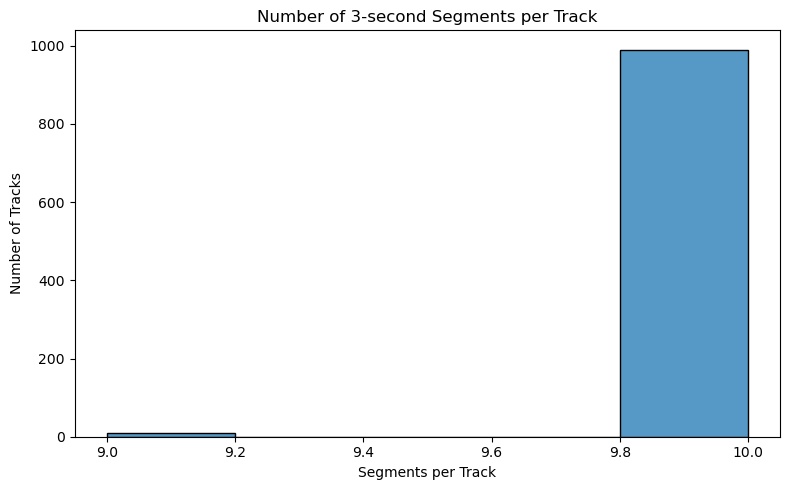

In [35]:
segment_counts = df.groupby("track_id").size()

plt.figure(figsize=(8,5))
sns.histplot(segment_counts, bins=5)
plt.title("Number of 3-second Segments per Track")
plt.xlabel("Segments per Track")
plt.ylabel("Number of Tracks")
plt.tight_layout()
plt.show()


This histogram illustrates the number of 3-second audio segments associated with each music track in the GTZAN dataset. The vast majority of tracks contain exactly ten segments, corresponding to the expected segmentation of 30-second audio excerpts. A small number of tracks contain only nine segments, likely due to minor preprocessing inconsistencies or truncated recordings. This analysis supports the decision to construct fixed-length time-series representations by selecting a maximum of ten segments per track, ensuring consistent input dimensionality for sequential neural network models.

### 2.4 Data Leakage Risk

Because each track is split into multiple temporal segments, a naive random split of rows would result 
in segments from the same track appearing in both training and test sets.

This would lead to **data leakage** and overly optimistic performance estimates.

To prevent this, all dataset splits are performed at the **track level**, ensuring that all segments 
of a given track belong to the same subset.


In [20]:
#check how many segments exist
segment_counts = df.groupby(ID_COL).size()
segment_counts.describe()

count    9990.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64

In this GTZAN dataset, ``filename`` is not the name of the song, but a segment-level filename:
- blues.00000.000.wav
- blues.00000.001.wav
- blues.00000.002.wav
- ...

Each 3-second segment has a unique filename, so filename ≠ track.

For that reason, we need to extract the base track name and derive a ``track_id`` column, as a track identifier.


In [ ]:
df["track_id"] = df["filename"].apply(
    lambda x: ".".join(x.split(".")[:2])
)

df[["filename", "track_id"]]

,filename,track_id
0,blues.00000.0.wav,blues.00000
1,blues.00000.1.wav,blues.00000
2,blues.00000.2.wav,blues.00000
3,blues.00000.3.wav,blues.00000
4,blues.00000.4.wav,blues.00000
...,...,...
9985,rock.00099.5.wav,rock.00099
9986,rock.00099.6.wav,rock.00099
9987,rock.00099.7.wav,rock.00099
9988,rock.00099.8.wav,rock.00099


In [28]:
ID_COL = "track_id"
LABEL_COL = "label"

NON_FEATURE_COLS = ["filename", ID_COL, LABEL_COL]

if "length" in df.columns:
    NON_FEATURE_COLS.append("length")

FEATURE_COLS = [
    c for c in df.columns
    if c not in NON_FEATURE_COLS and pd.api.types.is_numeric_dtype(df[c])
]

print("Number of feature columns:", len(FEATURE_COLS))
FEATURE_COLS[:5]


Number of feature columns: 57


['chroma_stft_mean',
 'chroma_stft_var',
 'rms_mean',
 'rms_var',
 'spectral_centroid_mean']

So now if we re-check the segments, we can confirm that the grouping is correct and each group relates to a song.

In [29]:
segment_counts = df.groupby(ID_COL).size()
segment_counts.describe()

count    1000.000000
mean        9.990000
std         0.099549
min         9.000000
25%        10.000000
50%        10.000000
75%        10.000000
max        10.000000
dtype: float64

### 2.5 Time-Series Sequence Construction

For each music track, the corresponding 3-second audio segments are grouped together to form a fixed-length time series representation. Since each original audio excerpt has a duration of approximately 30 seconds, it is expected to be composed of around ten consecutive 3-second segments.

In this step, segments belonging to the same track are identified using a reconstructed track-level identifier and ordered temporally according to their filenames. Tracks with fewer than the expected number of segments are discarded to ensure consistent input dimensionality across all samples.

As a result, each track is represented as:
- A sequence of `T = 10` time steps, corresponding to consecutive 3-second windows
- Each time step containing `F = 57` numerical audio features

This transformation converts the original tabular dataset into a three-dimensional tensor of shape:


In [30]:
import numpy as np

EXPECTED_SEGMENTS = 10

X = [] #time series
y = [] #genre label
track_ids = []

for track, group in df.groupby("track_id"):
    if len(group) < EXPECTED_SEGMENTS:
        continue

    #temporal order
    group = group.sort_values("filename")
    group = group.iloc[:EXPECTED_SEGMENTS]

    X.append(group[FEATURE_COLS].values)
    y.append(group[LABEL_COL].iloc[0])
    track_ids.append(track)

X = np.array(X, dtype=np.float32)
y = np.array(y)
track_ids = np.array(track_ids)

print("Input shape (tracks, time steps, features):", X.shape)
print("Number of classes:", len(np.unique(y)))


Input shape (tracks, time steps, features): (990, 10, 57)
Number of classes: 10


### 2.6 Label Encoding

The target variable (music genre) is categorical and must be transformed into a numerical representation 
before training the models. Label encoding is used to map each genre to a unique integer value.

In [31]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

label_encoder.classes_

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype='<U9')

### 2.7 Train / Validation / Test Split

The dataset is split into training, validation, and test subsets using stratified sampling at the 
track level. This ensures that:
- No temporal segments from the same track appear in multiple subsets
- Genre distribution is preserved across splits

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded,
    test_size=0.30,
    stratify=y_encoded,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

X_train.shape, X_val.shape, X_test.shape


((693, 10, 57), (148, 10, 57), (149, 10, 57))

### 2.8 Feature Scaling

To improve training stability and convergence speed, all audio features are standardized using 
a `StandardScaler`. The scaler is fitted exclusively on the training data to prevent information leakage.


Prior to normalization, the distributions of selected features are inspected to assess scale differences and skewness.

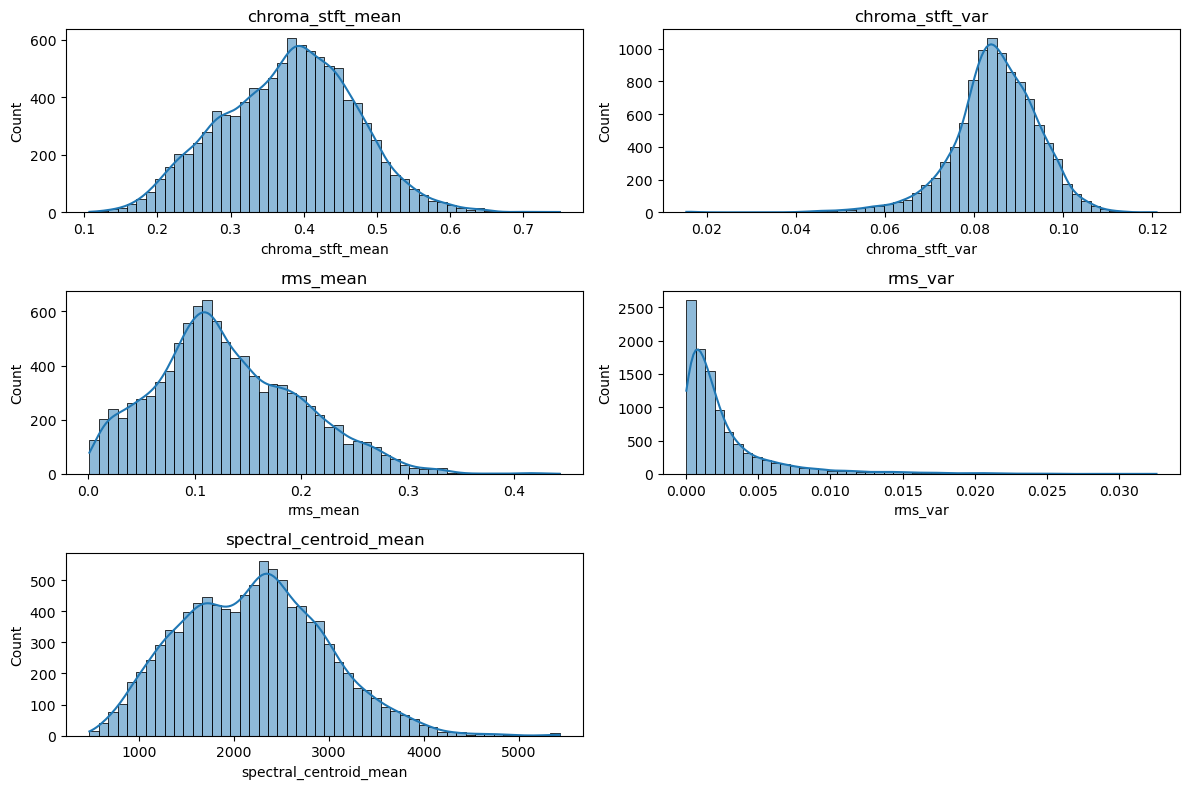

In [38]:
plt.figure(figsize=(12,8))
for i, feat in enumerate(sample_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[feat], bins=50, kde=True)
    plt.title(feat)

plt.tight_layout()
plt.show()


The temporal evolution plot also highlights significant differences in magnitude between features. For instance, the spectral centroid exhibits values several orders of magnitude larger than chroma or RMS features. This scale disparity further reinforces the need for feature standardization to prevent features with larger numerical ranges from dominating the learning process.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_flat = X_train.reshape(-1, X_train.shape[-1])
scaler.fit(X_train_flat)

def scale_sequences(X):
    return scaler.transform(
        X.reshape(-1, X.shape[-1])
    ).reshape(X.shape) # tracks x time, features instead tracks,time,features

X_train = scale_sequences(X_train)
X_val   = scale_sequences(X_val)
X_test  = scale_sequences(X_test)

X_train


array([[[-6.17186189e-01,  9.27032411e-01,  1.11366069e+00, ...,
          2.21016335e+00,  1.36903211e-01,  6.88956857e-01],
        [-1.62220567e-01,  8.41985881e-01,  1.66459894e+00, ...,
         -1.06011644e-01,  2.99422204e-01, -1.07595652e-01],
        [ 2.89826274e-01,  1.31251478e+00,  1.77051997e+00, ...,
          6.24225795e-01,  7.51786053e-01,  2.96619654e-01],
        ...,
        [-5.38216591e-01,  1.12638295e+00,  1.66721582e+00, ...,
          1.21669590e+00,  1.11910748e+00,  2.42142797e+00],
        [-8.36150944e-01,  1.27087563e-01,  2.01883936e+00, ...,
          1.43663198e-01,  8.35120022e-01,  7.92705894e-01],
        [-5.90736151e-01,  6.09053671e-01,  2.12145853e+00, ...,
          2.32584620e+00, -1.38833976e+00, -1.41777232e-01]],

       [[ 4.99208927e-01,  2.61748254e-01, -4.65297371e-01, ...,
         -5.62395930e-01,  2.10745949e-02, -5.09653389e-01],
        [ 5.23563564e-01, -3.22951004e-02, -3.61592054e-01, ...,
         -3.86690199e-01,  4.72498685e

We standardize features using statistics computed from all training time steps while preserving the three-dimensional time-series structure required by recurrent models.

### 2.9 Summary of Data Preparation

At the end of this phase, the original segment-level dataset has been transformed into a track-level representation suitable for sequential deep learning. Each music track is represented as a fixed-length time series of audio features, preserving temporal order while ensuring consistent input dimensionality.

All preprocessing steps were carefully designed to prevent data leakage. Segment grouping and dataset splitting were performed at the track level, and feature normalization was applied using statistics computed exclusively from the training data. Exploratory data analysis confirmed class balance, temporal coherence across segments, and the necessity of feature scaling due to heterogeneous feature distributions.

As a result, the final dataset is clean, well-structured, and standardized, providing a reliable foundation for training and evaluating recurrent and convolutional neural network models in the subsequent modeling phase.


## Phase 3 - Model Selection and Justification

This phase focuses on the **selection and justification of candidate models** for music genre classification.

Two main model families are explored:

1. **Classical machine learning baselines**, operating on aggregated track-level features.
2. **Sequential deep learning models**, operating directly on track-level time-series representations.

Model selection is performed using the **validation Macro F1-score**, which ensures balanced performance across all musical genres.

### Evaluation Strategy

The primary evaluation metric used throughout this phase is the **Macro F1-score**, as it equally weights all classes and is robust to potential class imbalance.

The dataset is divided into:
- Training set (70%)
- Validation set (15%)
- Test set (15%)

The **validation set** is used exclusively for model selection.  
The **test set** is used only once, for the final evaluation of the selected model.


In [41]:
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)

def evaluate_model(y_true, y_pred, label_encoder=None, prefix=""):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    precm = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recm = recall_score(y_true, y_pred, average="macro", zero_division=0)

    print(f"{prefix}Accuracy:        {acc:.4f}")
    print(f"{prefix}Macro F1-score:  {f1m:.4f}")
    print(f"{prefix}Macro Precision: {precm:.4f}")
    print(f"{prefix}Macro Recall:    {recm:.4f}\n")

    if label_encoder is not None:
        print(classification_report(
            y_true, y_pred,
            target_names=label_encoder.classes_,
            zero_division=0
        ))
    else:
        print(classification_report(y_true, y_pred, zero_division=0))

    return {
        "accuracy": acc,
        "macro_f1": f1m,
        "macro_precision": precm,
        "macro_recall": recm
    }

### 3.1 Baseline Models (Classical Machine Learning)

As a reference point, classical machine learning models are trained using **aggregated track-level features**.

Each track-level time series is summarized using:
- Mean of each feature across time
- Standard deviation of each feature across time

This produces a fixed-length representation per track and allows the use of traditional classifiers.


In [42]:
def aggregate_track_features(X):
    mean_features = X.mean(axis=1)
    std_features = X.std(axis=1)
    return np.concatenate([mean_features, std_features], axis=1)

X_train_agg = aggregate_track_features(X_train)
X_val_agg   = aggregate_track_features(X_val)
X_test_agg  = aggregate_track_features(X_test)

X_train_agg.shape, X_val_agg.shape, X_test_agg.shape

((693, 114), (148, 114), (149, 114))

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

baseline_models = {
    "Logistic Regression": LogisticRegression(max_iter=3000, n_jobs=-1),
    "SVM (RBF)": SVC(kernel="rbf", C=5.0, gamma="scale"),
    "Random Forest": RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
}

baseline_results = {}

for name, model in baseline_models.items():
    model.fit(X_train_agg, y_train)
    val_pred = model.predict(X_val_agg)

    print("=" * 70)
    print(f"Baseline Model: {name}")
    baseline_results[name] = evaluate_model(
        y_val, val_pred,
        label_encoder=label_encoder,
        prefix="[VAL] "
    )


Baseline Model: Logistic Regression
[VAL] Accuracy:        0.7973
[VAL] Macro F1-score:  0.7990
[VAL] Macro Precision: 0.8057
[VAL] Macro Recall:    0.7971

              precision    recall  f1-score   support

       blues       0.86      0.80      0.83        15
   classical       1.00      0.86      0.92        14
     country       0.93      0.87      0.90        15
       disco       0.53      0.60      0.56        15
      hiphop       0.71      0.71      0.71        14
        jazz       0.79      1.00      0.88        15
       metal       0.93      0.93      0.93        15
         pop       0.86      0.80      0.83        15
      reggae       0.73      0.73      0.73        15
        rock       0.71      0.67      0.69        15

    accuracy                           0.80       148
   macro avg       0.81      0.80      0.80       148
weighted avg       0.81      0.80      0.80       148

Baseline Model: SVM (RBF)
[VAL] Accuracy:        0.8378
[VAL] Macro F1-score:  0.838

### 3.1.2 Baseline Model Selection

Among the evaluated classical machine learning models, the Support Vector Machine with RBF kernel achieved the highest validation performance, with a Macro F1-score of approximately **0.84**.

This model is selected as the **reference baseline** for subsequent comparisons with sequential deep learning architectures. No further tuning is performed at this stage in order to preserve a fair and consistent comparison.


In [44]:
best_baseline_name = "SVM (RBF)"
best_baseline_model = baseline_models[best_baseline_name]

baseline_results[best_baseline_name]


{'accuracy': 0.8378378378378378,
 'macro_f1': 0.8379815844765789,
 'macro_precision': 0.8495168067226893,
 'macro_recall': 0.8380952380952381}

## 3.2 Sequential Deep Learning Models

While the baseline models operate on aggregated statistics and ignore temporal ordering, musical audio is inherently sequential.

Sequential neural networks are therefore evaluated to determine whether modeling the temporal evolution of audio features across consecutive segments provides additional discriminative power beyond global statistics.


In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(42)
np.random.seed(42)

NUM_CLASSES = len(np.unique(y_train))
INPUT_SHAPE = X_train.shape[1:]  # (time_steps, features)


In [46]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        patience=5,
        factor=0.5,
        min_lr=1e-6
    )
]

Early stopping and adaptive learning rate scheduling are used to regularize training and improve convergence. Early stopping monitors the validation loss and halts training when no further improvement is observed, restoring the best-performing model weights. In parallel, the learning rate is reduced when validation performance plateaus, enabling finer optimization steps and mitigating overfitting.


In [47]:
def build_lstm_model():
    inp = keras.Input(shape=INPUT_SHAPE)
    x = layers.LSTM(128, return_sequences=True)(inp)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(64)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inp, out, name="LSTM")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

lstm_model = build_lstm_model()
lstm_model.summary()

Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 57)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 128)        │        95,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,250 (602.54 KB)

 Trainable params: 154,250 (602.54 KB)

 Non-trainable params: 0 (0.00 B)

The LSTM architecture processes each music track as a sequence of 10 time steps with 57 audio features per step. The first LSTM layer, configured with 128 units and sequence output enabled, captures short-term temporal dependencies across consecutive segments. A second LSTM layer with 64 units aggregates this temporal information into a fixed-length representation. Fully connected layers are then used to model higher-level abstractions before producing genre probabilities via a softmax output. Dropout is applied after each major layer to mitigate overfitting. With approximately 154k trainable parameters, the model has sufficient capacity to learn temporal patterns but also exhibits a risk of overfitting given the limited dataset size.

In [48]:
history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

val_pred_lstm = np.argmax(lstm_model.predict(X_val), axis=1)

lstm_val_metrics = evaluate_model(
    y_val,
    val_pred_lstm,
    label_encoder=label_encoder,
    prefix="[VAL LSTM] "
)

lstm_val_metrics


Epoch 1/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.2973 - loss: 2.0863 - val_accuracy: 0.4122 - val_loss: 1.7266 - learning_rate: 0.0010
Epoch 2/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.4488 - loss: 1.6306 - val_accuracy: 0.5608 - val_loss: 1.3148 - learning_rate: 0.0010
Epoch 3/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.5859 - loss: 1.2618 - val_accuracy: 0.6419 - val_loss: 1.0315 - learning_rate: 0.0010
Epoch 4/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6768 - loss: 0.9966 - val_accuracy: 0.7095 - val_loss: 0.9090 - learning_rate: 0.0010
Epoch 5/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7374 - loss: 0.8026 - val_accuracy: 0.7095 - val_loss: 0.7994 - learning_rate: 0.0010
Epoch 6/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7937 - loss: 0.6702 - val_accuracy: 0.7432 - val_loss: 0.7712 - learning_rate: 0.0010
Epoch 7/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8297 - loss: 0.5701 - val_ac

{'accuracy': 0.777027027027027,
 'macro_f1': 0.7831534107890844,
 'macro_precision': 0.8050245879851143,
 'macro_recall': 0.7761904761904762}

The training dynamics indicate rapid convergence, with training accuracy exceeding 95% after approximately 12 epochs, while validation performance plateaus significantly earlier. Although validation accuracy reaches values above 0.80, the Macro F1-score stabilizes around 0.78, revealing uneven class-wise performance. The growing gap between training and validation loss after mid-training epochs is indicative of overfitting, despite the use of dropout and learning rate scheduling. These results suggest that, while the LSTM effectively memorizes training sequences, its ability to generalize temporal patterns across genres is limited for this feature representation, leading to inferior performance compared to the strongest non-temporal baseline.


### 3.3 Temporal Convolutional Model (CNN1D)

While recurrent neural networks model long-range temporal dependencies, convolutional architectures focus on learning **local temporal patterns** and are often more robust on short sequences.

A 1D Convolutional Neural Network (CNN1D) is therefore evaluated as an alternative sequential architecture to assess whether localized temporal dynamics improve classification performance.

In [49]:
def build_cnn1d_model():
    inp = keras.Input(shape=INPUT_SHAPE)

    x = layers.Conv1D(128, kernel_size=3, padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inp, out, name="CNN1D")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

cnn1d_model = build_cnn1d_model()
cnn1d_model.summary()

Model: "CNN1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 57)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 10, 128)        │        22,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,122 (352.04 KB)

 Trainable params: 89,610 (350.04 KB)

 Non-trainable params: 512 (2.00 KB)

In [50]:
history_cnn = cnn1d_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

val_pred_cnn = np.argmax(cnn1d_model.predict(X_val), axis=1)

cnn_val_metrics = evaluate_model(
    y_val,
    val_pred_cnn,
    label_encoder=label_encoder,
    prefix="[VAL CNN1D] "
)

cnn_val_metrics


Epoch 1/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.3348 - loss: 1.8974 - val_accuracy: 0.5000 - val_loss: 1.6431 - learning_rate: 0.0010
Epoch 2/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5801 - loss: 1.1687 - val_accuracy: 0.5473 - val_loss: 1.4072 - learning_rate: 0.0010
Epoch 3/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7071 - loss: 0.8743 - val_accuracy: 0.6351 - val_loss: 1.2000 - learning_rate: 0.0010
Epoch 4/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8038 - loss: 0.6421 - val_accuracy: 0.7230 - val_loss: 1.0550 - learning_rate: 0.0010
Epoch 5/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8384 - loss: 0.5512 - val_accuracy: 0.7770 - val_loss: 0.9283 - learning_rate: 0.0010
Epoch 6/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8932 - loss: 0.4030 - val_accuracy: 0.7973 - val_loss: 0.8403 - learning_rate: 5.0000e-04
Epoch 7/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9177 - loss: 0.3519 - val

{'accuracy': 0.5,
 'macro_f1': 0.4098392621870883,
 'macro_precision': 0.39857879437529337,
 'macro_recall': 0.5038095238095238}

The CNN1D model exhibits rapid improvement in training accuracy, reaching values above 95% within a few epochs, while validation performance remains unstable and substantially lower. Despite achieving a validation accuracy close to 0.84, the Macro F1-score collapses to approximately 0.41, indicating severe class-wise imbalance and poor discriminative capability. Several genres exhibit zero precision and recall, suggesting that the model converges to biased decision patterns that favor a subset of classes. This behavior indicates that local temporal convolution over short feature sequences is insufficient to capture the discriminative structure of the GTZAN time-series representation, resulting in poor generalization and rendering the CNN1D architecture unsuitable for this task.


### 3.4 Model Selection Outcome

The comparative evaluation demonstrates that classical machine learning models operating on aggregated track-level statistics outperform the evaluated sequential deep learning architectures.

Among all candidates, the ``Support Vector Machine with RBF kernel`` achieved the highest validation performance and is therefore selected as the final model for subsequent evaluation.

These results suggest that, for the GTZAN 3-second feature representation, global statistical descriptors capture the most discriminative information for music genre classification.
